In [69]:
import matplotlib.pyplot as plt
from numpy import sin, cos, exp, sign, tanh
import numpy as np
import matplotlib as mpl
import itertools as it
from scipy import integrate
from matplotlib.ticker import FormatStrFormatter
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "monospaced"
})

In [70]:
# mpl.rcParams.update(mpl.rcParamsDefault)

In [71]:
%matplotlib inline

In [72]:
# SMALL_SIZE = 8
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 12
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
# plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

fig_dpi = 175 # Dla wszystkich wykresów
fig_size = (10, 5)

In [73]:
plt.set_cmap('jet')

<Figure size 640x480 with 0 Axes>

In [74]:
# nie działa
# # żeby ploty wyglądały podobnie jak w matlabie
# plt.rcParams.update({
#     "text.usetex": True,
#     # "font.family": "monospaced"
# })

## <b> Model parameters

In [75]:
# M = 0.416
# mp = 0.089
# mc = 0
# Lp = 0.1215
# Lc = 2*Lp
# g = 9.8145
# mr = mp+mc
# Mt = M+mr
# L = (Lp*mp + Lc*mc) / mr
# Jcm = Lp**2 / mr * ( 4/3 * mr*(3 * mc + mp) - (2*mc + mp)**2 )
# Jcm = 0.3333333*mp*Lp**2 + mp*(L-Lp)**2 + mc*(L-Lc)**2;
# # Jcm = 1/12*mp*Lp**2
# Jt = Jcm + mr*L**2
# gamma = 0.0035 # lepki
# # gamma = 0.0067 # stribeck
# b_lepkie = 23.8299
# b_stribeck = 20.9
# miu_c      = 0.0651
# miu_s      = 0.1284
# vs         = 13.9987
# i          = 2
# delta      = 600
# D = 0
# c1 = 1.5417 # lepki
# c2 = 0 # beta

# # params lepkie
# params_visc = [M, mc, mp, Lp, Lc, g, b_lepkie, gamma, D, mr, Mt, L, Jcm, Jt]

# # params Stribeck
# params_stri = [M, mc, mp, Lp, Lc, g, b_stribeck, gamma, D, mr, Mt, L, Jcm, Jt, miu_c, miu_s, vs, i]
M = 0.4178
mp = 0.089
mc = 0
Lp = 0.1213
Lc = 2*Lp
g = 9.8145
mr = mp+mc
Mt = M+mr
L = (Lp*mp + Lc*mc) / mr
Jcm = Lp**2 / mr * ( 4/3 * mr*(3 * mc + mp) - (2*mc + mp)**2 )
Jcm = 1/12 * mp * Lp**2
Jt = Jcm + mr*L**2
# tarcie w osi ramienia
gamma = 0.0028
# Viscous friction
b_lepkie = 1.5
# Stribeck friction 
b_stribeck = 3
miu_c      = 0.04287
miu_s      = 0.0861
vs         = 0.105
i          = 2
delta      = 400

D = 0

c1 = 1.719 # alfa
c2 = 7.682 # beta

# params viscous
params_visc = [M, mc, mp, Lp, Lc, g, b_lepkie, gamma, D, mr, Mt, L, Jcm, Jt]

# params Stribeck
params_stri = [M, mc, mp, Lp, Lc, g, b_stribeck, gamma, D, mr, Mt, L, Jcm, Jt, miu_c, miu_s, vs, i]


## <b> Functions for numerical simulation for scipy.integrate.odeint

In [76]:
def step(t, jt):
    ''' jt - jump time '''
    return 1 if  t > jt else 0

def u_func(t, x1, x2, x3, x4):
    # return step(t, 2);
    # return 30*x2
    return 0

In [77]:
delat_stribeck = 600 # delta?

In [78]:
def ddt_state_viscous(state, t, u_func, params):
    '''
        Function used for scipy.integrate.odeint to generate sample state trajectory (ode solution)
        state = ( x  theta  Dx  Dtheta )
                ( x1  x2    x3    x4   )
    '''
    x1, x2, x3, x4 = state
    ################################################################
    M, mc, mp, Lp, Lc, g, b, gamma, D, mr, Mt, L, Jcm, Jt = params
    ################################################################
    u=u_func(t, x1, x2, x3, x4);
    
    den = Jt*Mt - L**2 * mr**2 * cos(x2)
    ################################################################
    Ff = b * x3
    ################################################################
    
    ddt_x1 = x3
    ddt_x2 = x4
    ddt_x3 = ( Jt*(D*cos(x2) + L*mr*x4**2*sin(x2) - Ff + u) - \
                L*mr*cos(x2) * ( D*Lc + L*g*mr*sin(x2) - gamma*x4 ) ) \
                / den
    
    ddt_x4 = ( -L*mr*cos(x2) * (D*cos(x2) + L*mr*x4**2*sin(x2) - Ff + u) + \
                Mt * ( D*Lc + L*g*mr*sin(x2) - gamma*x4 ) ) \
                / den
    
    return (ddt_x1, ddt_x2, ddt_x3, ddt_x4)

def ddt_state_stribeck(state, t, u_func, params):
    '''
        Function used for scipy.integrate.odeint to generate sample state trajectory (ode solution)
        state = ( x  theta  Dx  Dtheta )
                ( x1  x2    x3    x4   )
    '''
    x1, x2, x3, x4 = state
    # extra params for stribeck friction: uc, us, vs, i
    M, mc, mp, Lp, Lc, g, b, gamma, D, mr, Mt, L, Jcm, Jt, uc, us, vs, i = params

    # u=u_func(t)
    u=u_func(t, x1, x2, x3, x4);
    den = Jt*Mt - L**2 * mr**2 * cos(x2)

    ######
    Ff = ( uc + (us-uc)*exp(-(x3/vs)**i) ) * Mt * g * tanh(delat_stribeck*x3) + b*x3
    ######
    
    ddt_x1 = x3
    ddt_x2 = x4
    ddt_x3 = ( Jt*(D*cos(x2) + L*mr*x4**2*sin(x2) - Ff + u) - \
                L*mr*cos(x2) * ( D*Lc + L*g*mr*sin(x2) - gamma*x4 ) ) \
                / den
    
    ddt_x4 = ( -L*mr*cos(x2) * (D*cos(x2) + L*mr*x4**2*sin(x2) - Ff + u) + \
                Mt * ( D*Lc + L*g*mr*sin(x2) - gamma*x4 ) ) \
                / den
    
    return (ddt_x1, ddt_x2, ddt_x3, ddt_x4)

In [79]:
# value to list index
from math import ceil
def get_idx_from_vals(maxv, minv, step, value):
    '''
        eg.  x_arr = [1.2, 1.4, 1.6, 1.8]
            get_idx_from_vals(1.4) >>> returns: idx = 1 
    '''
    arr_len = (maxv - minv) / step + 1
    slope = (arr_len - 1) / (maxv - minv)
    idx = lambda elem: ceil(slope*(elem - minv))
    
    idx = ceil(slope*(value - minv))
    
    return idx

# eg. use #
if 0:
    temp = np.arange(-3, 1.1, 0.1)
    disp(list( enumerate(temp) )[30:37])
    print('number .5 index is: ', get_idx_from_vals(1, -3, 0.1, 0.5))

# <b> 1 <u> Model with viscous friction

## 1.1 Testing different initial conditions

In [80]:
# Sample trajectories
dt = 0.001
start_t = 0
stop_t = 6
sim_time = np.arange(start_t, stop_t+dt, dt)

# Initial conditions, state = ( x  theta  Dx  Dtheta )
ic_states = np.array([
    [0, 5*np.pi/180, 0, 0],
    [0, -10*np.pi/180, 0, 0],
    [0, 100*np.pi/180, 0, 140*np.pi/180],
    [0, 200*np.pi/180, 0, -150*np.pi/180],
    [0, 0, 0, -500*np.pi/180],
    [0, 90*np.pi/180, 100, -500*np.pi/180],
    [0, 0, 50, -40*np.pi/180]
])

# czasami gdy nie ma ustawionego hmax, solver
# optymalizuje dt i wtedy u_func nie działa poprawnie
# u_func gdy ma 'step(t)' jest nieciągła - to dla tego
sols = []
for ic in ic_states:
    state_trajectory = integrate.odeint(
        func=ddt_state_viscous,
        y0=ic,
        t=sim_time,
        args=(u_func, params_visc),
        h0=dt,
        hmax=dt) 
    sols.append(state_trajectory)  

sols = np.transpose(sols)
x, theta, Dx, Dtheta = sols

theta = np.transpose(theta)
Dtheta = np.transpose(Dtheta)
x = np.transpose(x)
Dx = np.transpose(Dx)

# rad to deg
theta = theta * 180/np.pi
Dtheta = Dtheta * 180/np.pi

ic_states[:, 1] *= 180/np.pi
ic_states[:, 3] *= 180/np.pi

# for i, the in enumerate(theta):
#     ic_states[i][1] *= 180/np.pi
#     ic_states[i][3] *= 180/np.pi

## 1.2 $\theta(t)$

In [81]:
nazwa = 'vis_theta_od_t.jpg'
save = 1

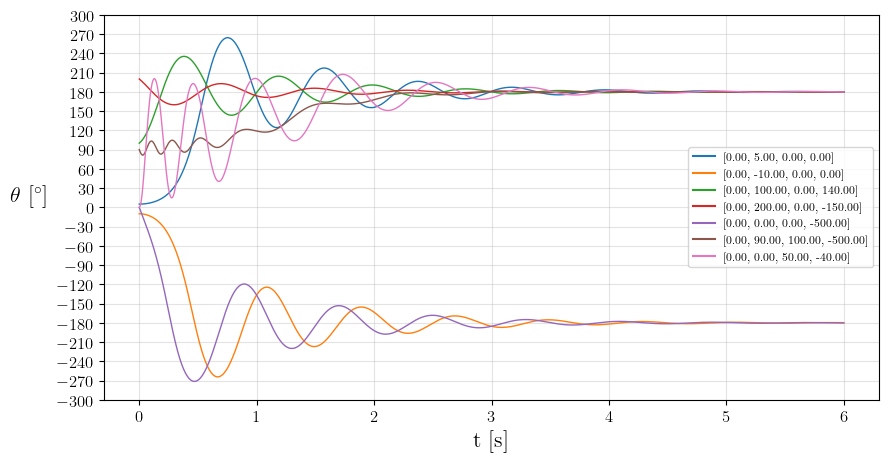

In [82]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=fig_size, dpi=100, sharey=True, sharex=True)

ax.grid(alpha=0.35)

ax.set_xlabel("t [s]")
ax.set_ylabel(r"$\theta$ [$^\circ$]", rotation=0, labelpad=20)

for i, the in enumerate(theta):
    # ic_states[i][1] *= 180/np.pi
    # ic_states[i][3] *= 180/np.pi
    '{:#^{width}}'.format(' USA ', width=19)
    lab = '[{:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*ic_states[i], width=12)
    ax.plot(sim_time, the, label=lab);

ax.legend()
    
for line in ax.get_lines():
    line.set_linewidth(1)
    
ax.set_yticks([i for i in range(-300, 320, 30)])

if save:
    plt.savefig(f'./{nazwa}', dpi=fig_dpi)
plt.show()

## 1.3 $\dot{\theta}(t)$

In [83]:
nazwa = 'vis_theta_dot_od_t.jpg'
save = 1

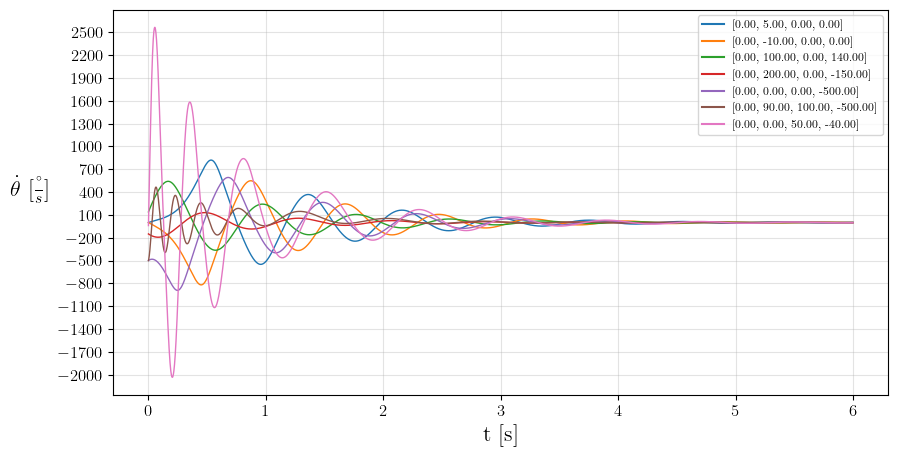

In [84]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=fig_size, dpi=100, sharey=True, sharex=True)

ax.grid(alpha=0.35)

ax.set_xlabel("t [s]")
ax.set_ylabel(r"$\dot{\theta}$ [$\frac{^\circ}{s}$]", rotation=0, labelpad=20)

for i, the in enumerate(Dtheta):
    # ic_states[i][1] *= 180/np.pi
    # ic_states[i][3] *= 180/np.pi
    '{:#^{width}}'.format(' USA ', width=19)
    lab = '[{:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*ic_states[i], width=12)
    ax.plot(sim_time, the, label=lab);

ax.legend()
    
for line in ax.get_lines():
    line.set_linewidth(1)
    
# ax.set_yticks([i for i in range(-220, 240, 20)])
ax.set_yticks([i for i in range(-2000, 2800, 300)])

if save:
    plt.savefig(f'./{nazwa}', dpi=fig_dpi)
plt.show()

## 1.4 $x_{\mathrm{w}}(t)$

In [85]:
# from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes

In [86]:
nazwa = 'vis_x_od_t.jpg'
save = 1

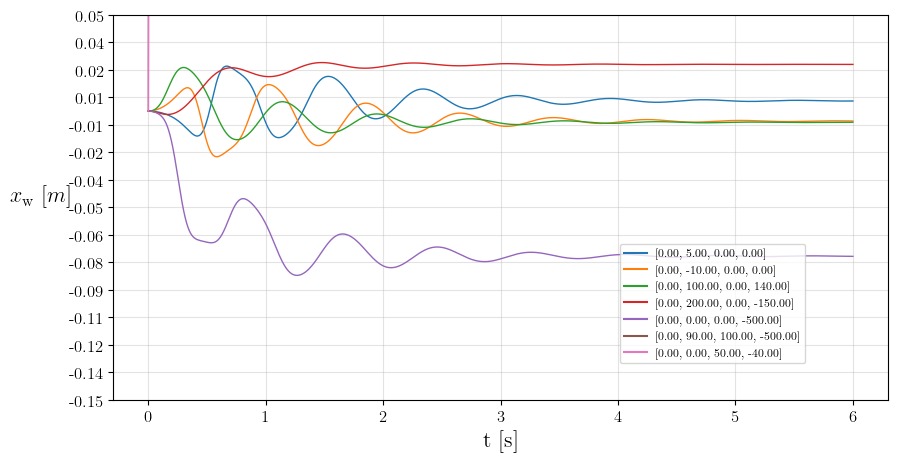

In [87]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=fig_size, dpi=100, sharey=True, sharex=True)

ax.grid(alpha=0.35)

ax.set_xlabel("t [s]")
ax.set_ylabel(r"$x_{\mathrm{w}}$ $[m]$", rotation=0, labelpad=20)

for i, the in enumerate(x):
    # ic_states[i][1] *= 180/np.pi
    # ic_states[i][3] *= 180/np.pi
    lab = '[{:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*ic_states[i], width=12)
    ax.plot(sim_time, the, label=lab);

ax.legend(loc=5, bbox_to_anchor=(0.5, 0., 0.4, 0.5))
    
for line in ax.get_lines():
    line.set_linewidth(1)
    
ax.set_ylim([-0.15, 0.05])
# ax.set_yticks([i for i in range(-0.4, 0.2, 0.05)])
ax.set_yticks(np.linspace(-0.15,0.05, 15))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
if save:
    plt.savefig(f'./{nazwa}', dpi=fig_dpi)
plt.show()

## 1.5 $\dot{x}_{\mathrm{w}}(t)$

In [88]:
nazwa = 'vis_x_dot_od_t.jpg'
save = 1

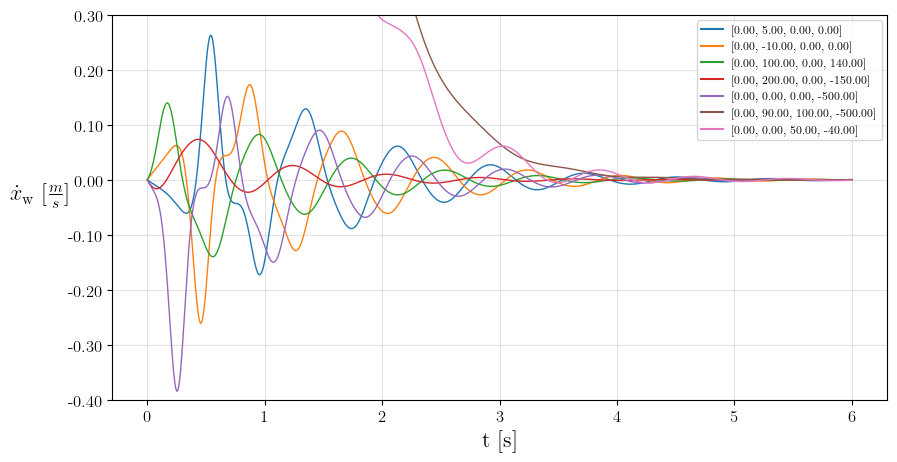

In [89]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=fig_size, dpi=100, sharey=True, sharex=True)

ax.grid(alpha=0.35)

ax.set_xlabel("t [s]")
ax.set_ylabel(r"$\dot{x}_{\mathrm{w}}$ [$\frac{m}{s}$]", rotation=0, labelpad=20)

for i, the in enumerate(Dx):
    lab = '[{:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*ic_states[i], width=12)
    ax.plot(sim_time, the, label=lab);

ax.legend(loc='best')
    
for line in ax.get_lines():
    line.set_linewidth(1)
    
ax.set_ylim([-0.4, 0.3])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
if save:
    plt.savefig(f'./{nazwa}', dpi=fig_dpi)
plt.show()

# <b> 2 <u> Model with stribeck friction

## 2.1 Testing different initial conditions 

In [90]:
# Sample trajectories
dt = 0.0001
start_t = 0
stop_t = 6
sim_time = np.arange(start_t, stop_t+dt, dt)

# Initial conditions, state = ( x  theta  Dx  Dtheta )
ic_states = np.array([
    [0, 5*np.pi/180, 0, 0],
    [0, -10*np.pi/180, 0, 0],
    [0, 100*np.pi/180, 0, 140*np.pi/180],
    [0, 200*np.pi/180, 0, -150*np.pi/180],
    [0, 0, 0, -500*np.pi/180],
    [0, 90*np.pi/180, 100, -500*np.pi/180],
    [0, 0, 50, -40*np.pi/180]
])

# czasami gdy nie ma ustawionego hmax, solver
# optymalizuje dt i wtedy u_func nie działa poprawnie
# u_func gdy ma 'step(t)' jest nieciągła - to chyba dla tego
sols = []
for ic in ic_states:
    state_trajectory = integrate.odeint(
        func=ddt_state_stribeck,
        y0=ic,
        t=sim_time,
        args=(u_func, params_stri),
        h0=dt,
        hmax=dt) 
    sols.append(state_trajectory)  
    
sols = np.transpose(sols)
x, theta, Dx, Dtheta = sols

theta = np.transpose(theta)
Dtheta = np.transpose(Dtheta)
x = np.transpose(x)
Dx = np.transpose(Dx)

# rad to deg
theta = theta * 180/np.pi
Dtheta = Dtheta * 180/np.pi

ic_states[:, 1] *= 180/np.pi
ic_states[:, 3] *= 180/np.pi

# for i, the in enumerate(theta):
#     ic_states[i][1] *= 180/np.pi
#     ic_states[i][3] *= 180/np.pi

## 2.2 $\theta(t)$

In [91]:
nazwa = 'str_theta_od_t.jpg'
save = 1

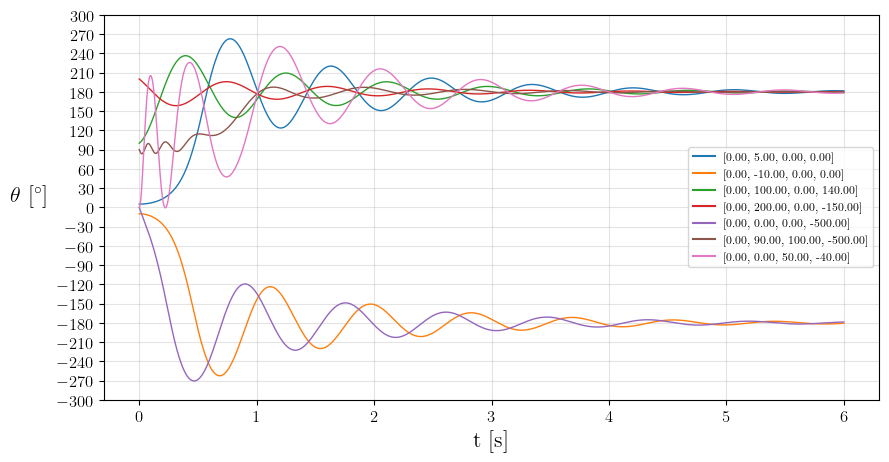

In [92]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=fig_size, dpi=100, sharey=True, sharex=True)

ax.grid(alpha=0.35)

ax.set_xlabel("t [s]")
ax.set_ylabel(r"$\theta$ [$^\circ$]", rotation=0, labelpad=20)

for i, the in enumerate(theta):
    # ic_states[i][1] *= 180/np.pi
    # ic_states[i][3] *= 180/np.pi
    '{:#^{width}}'.format(' USA ', width=19)
    lab = '[{:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*ic_states[i], width=12)
    ax.plot(sim_time, the, label=lab);

ax.legend()
    
for line in ax.get_lines():
    line.set_linewidth(1)
    
ax.set_yticks([i for i in range(-300, 320, 30)])

if save:
    plt.savefig(f'./{nazwa}', dpi=fig_dpi)
plt.show()

## 2.3 $\dot{\theta}(t)$

In [93]:
nazwa = 'str_theta_dot_od_t.jpg'
save = 1

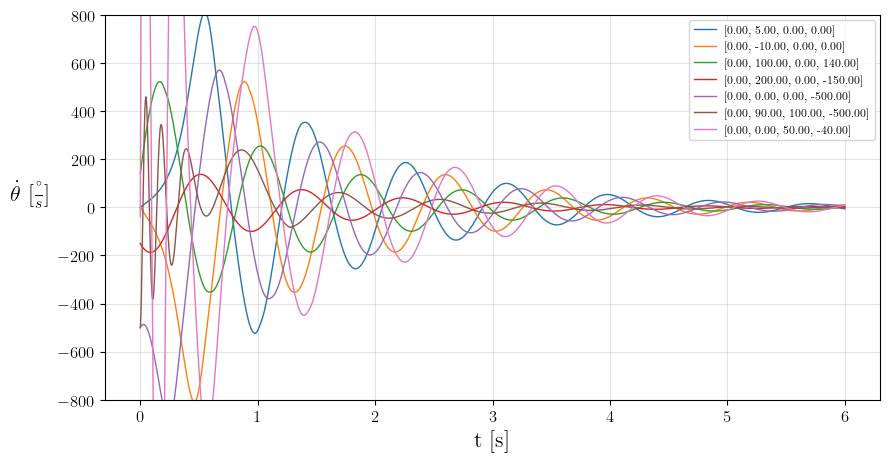

In [94]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=fig_size, dpi=100, sharey=True, sharex=True)

ax.grid(alpha=0.35)

ax.set_xlabel("t [s]")
ax.set_ylabel(r"$\dot{\theta}$ [$\frac{^\circ}{s}$]", rotation=0, labelpad=20)

for i, the in enumerate(Dtheta):
    # ic_states[i][1] *= 180/np.pi
    # ic_states[i][3] *= 180/np.pi
    '{:#^{width}}'.format(' USA ', width=19)
    lab = '[{:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*ic_states[i], width=12)
    ax.plot(sim_time, the, label=lab);

ax.legend()
    
for line in ax.get_lines():
    line.set_linewidth(1)
    
# ax.set_yticks([i for i in range(-220, 240, 20)])
ax.legend(loc='best')

ax.set_ylim([-800, 800])
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
if save:
    plt.savefig(f'./{nazwa}', dpi=fig_dpi)
plt.show()

## 2.4 $x_{\mathrm{w}}(t)$

In [95]:
nazwa = 'str_x_od_t.jpg'
save = 1

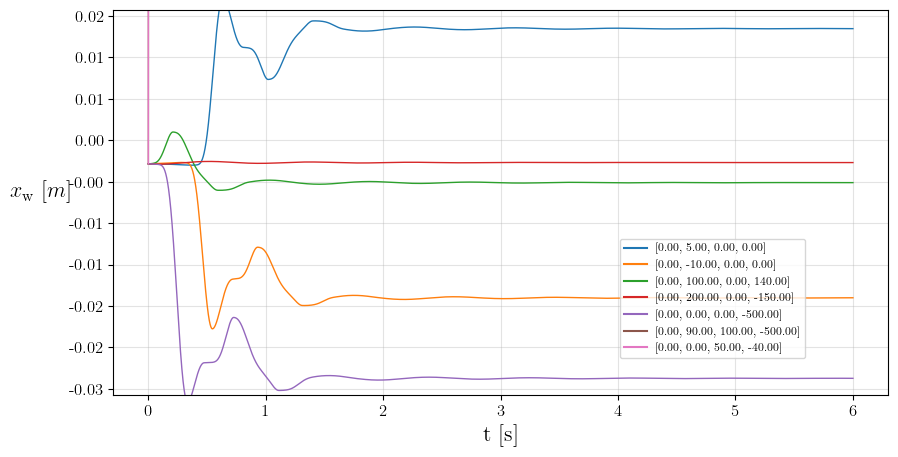

In [96]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=fig_size, dpi=100, sharey=True, sharex=True)

ax.grid(alpha=0.35)

ax.set_xlabel("t [s]")
ax.set_ylabel(r"$x_{\mathrm{w}}$ [$m$]", rotation=0, labelpad=20)

for i, the in enumerate(x):
    # ic_states[i][1] *= 180/np.pi
    # ic_states[i][3] *= 180/np.pi
    lab = '[{:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*ic_states[i], width=12)
    ax.plot(sim_time, the, label=lab);

ax.legend(loc=5, bbox_to_anchor=(0.5, 0., 0.4, 0.5))
    
for line in ax.get_lines():
    line.set_linewidth(1)
    

# ax.legend(loc='best')

# ax.set_ylim([-800, 800])
ax.set_yticks(np.linspace(-0.04, 0.03, 14))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_ylim([-0.03, 0.02])
if save:
    plt.savefig(f'./{nazwa}', dpi=fig_dpi)
plt.show()

## 2.5 $\dot{x}_{\mathrm{w}}(t)$

In [97]:
nazwa = 'str_x_dot_od_t.jpg'
save = 1

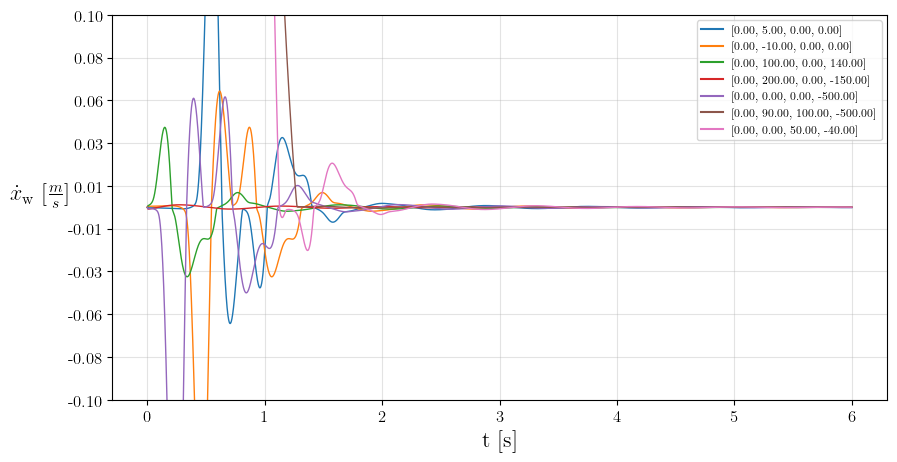

In [98]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=fig_size, dpi=100, sharey=True, sharex=True)

ax.grid(alpha=0.35)

ax.set_xlabel("t [s]")
ax.set_ylabel(r"$\dot{x}_{\mathrm{w}}$ [$\frac{m}{s}$]", rotation=0, labelpad=20)

for i, the in enumerate(Dx):
    lab = '[{:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*ic_states[i], width=12)
    ax.plot(sim_time, the, label=lab);

ax.legend(loc='best')
    
for line in ax.get_lines():
    line.set_linewidth(1)

ax.set_yticks(np.linspace(-0.1, 0.1, 10))
ax.set_ylim([-0.1, 0.1])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

if save:
    plt.savefig(f'./{nazwa}', dpi=fig_dpi)
plt.show()

## 2.6 Step response

In [99]:
# def ddt_state_viscous(state, t, u_func, params):
#     '''
#         Function used for scipy.integrate.odeint to generate sample state trajectory (ode solution)
#         state = ( x  theta  Dx  Dtheta )
#                 ( x1  x2    x3    x4   )
#     '''
#     x1, x2, x3, x4 = state
#     ################################################################
#     M, mc, mp, Lp, Lc, g, b, gamma, D, mr, Mt, L, Jcm, Jt = params
#     ################################################################
#     u=u_func(t);
    
#     den = Jt*Mt - L**2 * mr**2 * cos(x2)
#     ################################################################
#     Ff = b * x3
#     ################################################################
    
#     ddt_x1 = x3
#     ddt_x2 = x4
#     ddt_x3 = ( Jt*(D*cos(x2) + L*mr*x4**2*sin(x2) - Ff + u) - \
#                 L*mr*cos(x2) * ( D*Lc + L*g*mr*sin(x2) - gamma*x4 ) ) \
#                 / den
    
#     ddt_x4 = ( -L*mr*cos(x2) * (D*cos(x2) + L*mr*x4**2*sin(x2) - Ff + u) + \
#                 Mt * ( D*Lc + L*g*mr*sin(x2) - gamma*x4 ) ) \
#                 / den
    
#     return (ddt_x1, ddt_x2, ddt_x3, ddt_x4)

# def ddt_state_stribeck(state, t, u_func, params):
#     '''
#         Function used for scipy.integrate.odeint to generate sample state trajectory (ode solution)
#         state = ( x  theta  Dx  Dtheta )
#                 ( x1  x2    x3    x4   )
#     '''
#     x1, x2, x3, x4 = state
#     # extra params for stribeck friction: uc, us, vs, i
#     M, mc, mp, Lp, Lc, g, b, gamma, D, mr, Mt, L, Jcm, Jt, uc, us, vs, i = params

#     u=u_func(t)
#     den = Jt*Mt - L**2 * mr**2 * cos(x2)

#     ######
#     Ff = ( uc + (us-uc)*exp(-(x3/vs)**i) ) * Mt * g * tanh(delat_stribeck*x3) + b*x3
#     ######
    
#     ddt_x1 = x3
#     ddt_x2 = x4
#     ddt_x3 = ( Jt*(D*cos(x2) + L*mr*x4**2*sin(x2) - Ff + u) - \
#                 L*mr*cos(x2) * ( D*Lc + L*g*mr*sin(x2) - gamma*x4 ) ) \
#                 / den
    
#     ddt_x4 = ( -L*mr*cos(x2) * (D*cos(x2) + L*mr*x4**2*sin(x2) - Ff + u) + \
#                 Mt * ( D*Lc + L*g*mr*sin(x2) - gamma*x4 ) ) \
#                 / den
    
#     return (ddt_x1, ddt_x2, ddt_x3, ddt_x4)

In [100]:
# delat_stribeck = 600
# def step(t, jt):
#     ''' jt - jump time '''
#     return 1 if  t > jt else 0

# def u_func(t):
#     ret = step(t, 1) - step(t, 2)
#     return ret

In [101]:
# # Sample trajectories
# dt = 0.001
# start_t = 0
# stop_t = 6
# sim_time = np.arange(start_t, stop_t+dt, dt)

# # Initial conditions, state = ( x  theta  Dx  Dtheta )
# ic_states = np.array([
#     [0, 0*np.pi/180, 0, 0]
# ])

# # czasami gdy nie ma ustawionego hmax, solver
# # optymalizuje dt i wtedy u_func nie działa poprawnie
# # u_func gdy ma 'step(t)' jest nieciągła - to dla tego
# sols = []
# for ic in ic_states:
#     state_trajectory = integrate.odeint(
#         func=ddt_state_viscous,
#         y0=ic,
#         t=sim_time,
#         args=(u_func, params_visc),
#         h0=dt,
#         hmax=dt) 
#     sols.append(state_trajectory)  

# sols = np.transpose(sols)
# x, theta, Dx, Dtheta = sols

# # theta = np.transpose(theta)
# # Dtheta = np.transpose(Dtheta)
# # x = np.transpose(x)
# # Dx = np.transpose(Dx)
# # sim_time = np.transpose(sim_time)

# # rad to deg
# theta = theta * 180/np.pi
# Dtheta = Dtheta * 180/np.pi

# ic_states[:, 1] *= 180/np.pi
# ic_states[:, 3] *= 180/np.pi

# # for i, the in enumerate(theta):
# #     ic_states[i][1] *= 180/np.pi
# #     ic_states[i][3] *= 180/np.pi

In [102]:
# save = 0
# nazwa = "a"

# fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=fig_size, dpi=100, sharey=True, sharex=True)

# ax.grid(alpha=0.35)

# ax.set_xlabel("t [s]")
# ax.set_ylabel(r"$\theta$ [$^\circ$]", rotation=0, labelpad=20)

# # ax.plot(sim_time, theta, label='the');
# # ax.plot(sim_time Dtheta, label='Dthe');
# ax.plot(sim_time, x, label='xw');
# # ax.plot(sim_time, Dx, label='Dxw');

# ax.legend()
    
# for line in ax.get_lines():
#     line.set_linewidth(1)
    
# # ax.set_yticks([i for i in range(-2, 3, 1)])

# # if save:
# #     plt.savefig(f'./obrazki/do_pracy/{nazwa}', dpi=300)

# plt.show()